In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
from skimage.transform import resize

Using TensorFlow backend.


In [15]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename):  

    print('Load file {} ...'.format(filename))
    dcm = pydicom.dcmread(filename)
    img = dcm.pixel_array
    
    body_part = dcm.BodyPartExamined
    position = dcm.PatientPosition
    modality = dcm.Modality
    
    if body_part not in ['CHEST', 'chest', 'Chest']:
        print('Image {} rejected due to body part {}'.format(filename, body_part))

    if position not in ['PA', 'AP']:
        print('Image {} rejected due to position {}'.format(filename, position))

    if modality not in ['DX']:
        print('Image {} rejected due to modality {}'.format(filename, modality))

    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_size): 
    '''
    This function takes a numpy array output by check_dicom and 
    performs the appropriate preprocessing required for our model input.
    '''
    img = img / 255
    img = resize(img, img_size)
    proc_img = np.resize(np.zeros((224,224,3)),(1,224,224,3))
    
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    json_file = open(model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    
    model.load_weights(weight_path)
    print(model)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    pred = model.predict(img)
    prediction = pred > thresh
    
    return prediction[0][0]

def dcm_pred(filename):    
    img = np.array([])
    img = check_dicom(filename)
    
    if img is None:
        return 'Ineligible'
        
    img_proc = preprocess_image(img,img_size)
    pred = predict_image(my_model,img_proc,thresh)
    return pred


Load file test1.dcm ...
Load file test2.dcm ...
Load file test3.dcm ...
Load file test4.dcm ...
Image test4.dcm rejected due to body part RIBCAGE
Load file test5.dcm ...
Image test5.dcm rejected due to modality CT
Load file test6.dcm ...
Image test6.dcm rejected due to position XX


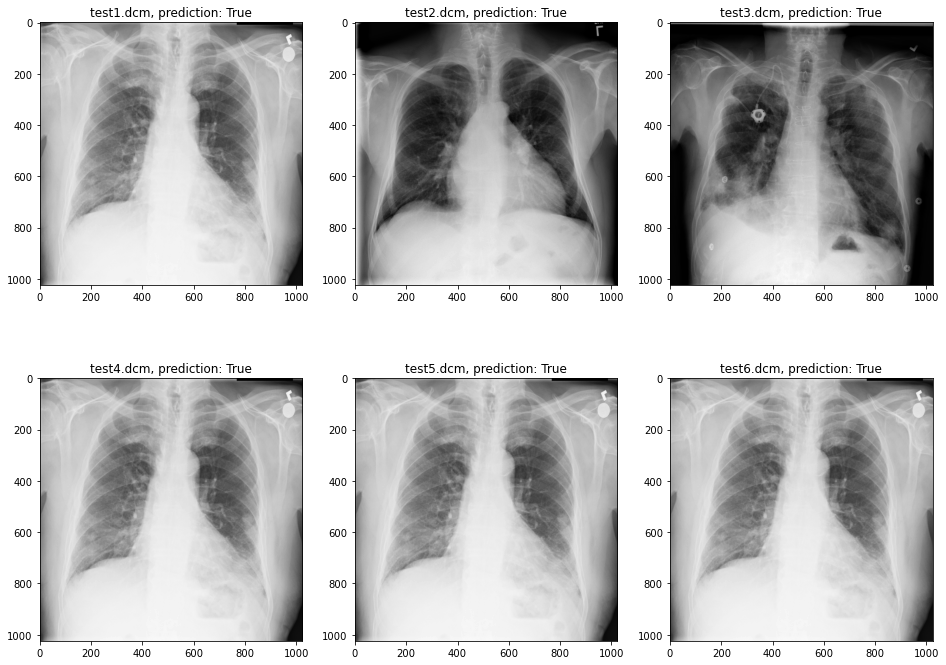

In [16]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'vgg-attn-model.json'
weight_path = 'weights/vgg-attn_weights.best.hdf5'

img_size=(1,224,224,3)
img_mean = -1
img_std = -1

my_model = load_model(model_path, weight_path)
thresh = 0.41

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(12)
# use the .dcm files to test your prediction
for i, filename in enumerate(test_dicoms):
    pred = dcm_pred(filename)
    img = pydicom.dcmread(filename).pixel_array        
    s = f.add_subplot(2, 3, i+1)
    s.set_title(f'{filename}, prediction: {pred}')
    plt.imshow(img, cmap='gray')
plt.show()